In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.io.shapereader as shapereader
import numpy as np
import math
import pdb

## Create map of the River Shannon

In [2]:
SHANNON_EXTENT = [-10, -8, 52.4, 53]
# SHANNON_LAKES = frozenset(["Lough Derg", "Lough Ree", "Lough Allen"])

In [3]:
land_masses_file = shapereader.natural_earth(
    resolution = "10m",
    category = 'physical',
    name="land_scale_rank"
)

land_shp = shapereader.Reader(land_masses_file)

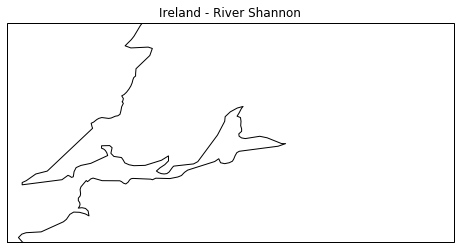

In [4]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.epsg(2158))

ax.set_title("Ireland - River Shannon")

for rec in land_shp.records():
    ax.add_geometries([rec.geometry], ccrs.PlateCarree(), edgecolor="black", facecolor='none')

ax.set_extent(SHANNON_EXTENT)

## Extracting coordiantes of the river

In [5]:
shannon_coords = []

## For one of the entries we get a Ploygon with a Multiline string instead of Linestring. We just iterative over the Mutliline to get the invidual LineStrings

for rec in land_shp.records():
    for polygon in rec.geometry:
        try:
            for coord in polygon.boundary.coords:
                if (coord[0] > SHANNON_EXTENT[0] and coord[0] < SHANNON_EXTENT[1]) and (coord[1] > SHANNON_EXTENT[2] and coord[1] < SHANNON_EXTENT[3]):
                    shannon_coords.append(coord)
        except:
            for linestring in polygon.boundary:
                for coord in linestring.coords:
                    if (coord[0] > SHANNON_EXTENT[0] and coord[0] < SHANNON_EXTENT[1]) and (coord[1] > SHANNON_EXTENT[2] and coord[1] < SHANNON_EXTENT[3]):
                        shannon_coords.append(coord)

In [6]:
#Add two points off to the side so we can form a box
max_x = shannon_coords[-1][0] - 0.5 if shannon_coords[-1][0] < shannon_coords[0][0] else shannon_coords[0][0] - 0.5
shannon_coords.append([max_x, shannon_coords[-1][1]])
shannon_coords.append([max_x, shannon_coords[0][1]])

In [7]:
boundary_river = np.array(shannon_coords)

## Plot boundary

[-12, -8.5, 51.9, 53.1]

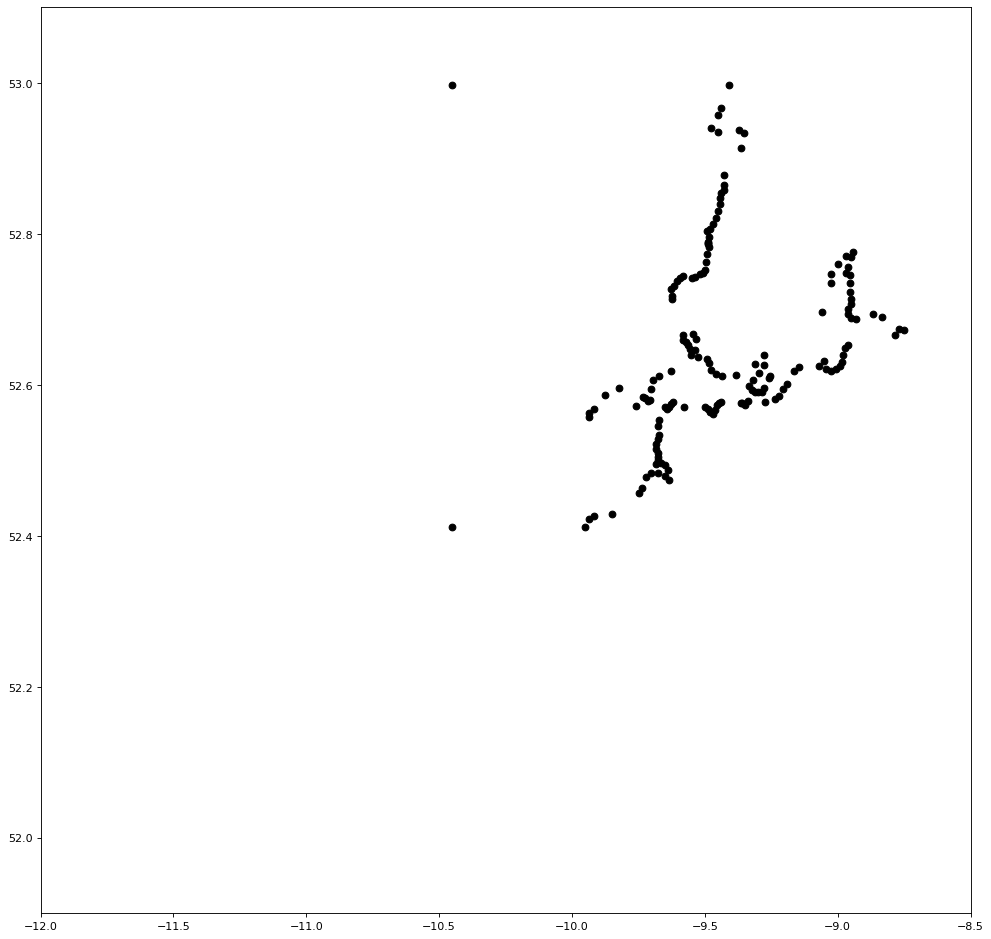

In [8]:
plt.figure(figsize=(15,15), dpi=80)
plt.plot(boundary_river[:,0], boundary_river[:,1], 'ko')

plt.axis([-12, -8.5, 51.9, 53.1])

## Creating the mesh

In [9]:
from meshpy.triangle import MeshInfo, build, refine

In [10]:
def round_trip_connect(start, end):
    result = []
    for i in range(start, end):
        result.append((i, i+1))
    result.append((end, start))
    return result

def needs_refinement(vertices, area ):
        vert_origin, vert_destination, vert_apex = vertices
        bary_x = (vert_origin.x + vert_destination.x + vert_apex.x) / 3
        bary_y = (vert_origin.y + vert_destination.y + vert_apex.y) / 3

        dist_center = math.sqrt( bary_x**2 + bary_y**2 )
        max_area = 100*(math.fabs( 0.002 * (dist_center-0.5) ) + 0.0001)
        return area > max_area

In [11]:
mesh_info = MeshInfo()
mesh_info.set_points(boundary_river)
mesh_info.set_facets(round_trip_connect(0, len(boundary_river) - 1))
mesh = build(mesh_info, refinement_func=needs_refinement)

In [ ]:
mesh.element_volumes.setup()

for i in range(len(mesh.elements)):
    mesh.element_volumes[i] = 1e-8
    
# for i in range(0, len(mesh.elements), 10):
#     mesh.element_volumes[i] = 1e-\
    
mesh = refine(mesh)

In [ ]:
pts = np.vstack(mesh.points)
elements = np.vstack(mesh.elements) 

plt.figure(figsize=(15,10), dpi=80)
plt.triplot(pts[:,0], pts[:,1], elements[:,:3])